
#Planar Classification
*   Binary Classification (cross entropy loss)
*   Satu hidden layer dengan fungsi aktivasi tanh



In [2]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline

%load_ext autoreload
%autoreload 2

##Load dataset

In [3]:
X, Y = load_planar_dataset()

##Visualisasi data

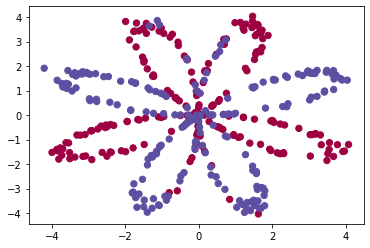

In [4]:
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

In [6]:
shape_X = X.shape
shape_Y = Y.shape
m = X.shape[1]

print ('shape_X: ' + str(shape_X))
print ('shape_Y: ' + str(shape_Y))
print ('Banyak data training: ' + str(m))

shape_X: (2, 400)
shape_Y: (1, 400)
Banyak data training: 400


##Menggunakan Simple Logistic Regression

In [7]:
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X.T, Y.T)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegressionCV()

###Plot Decision Boundary

Akurasi {(TP+TN)/m}: 47 % 


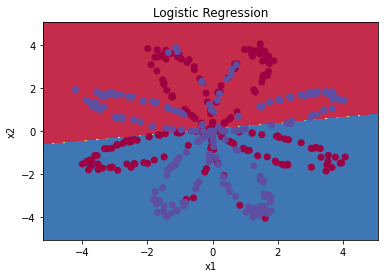

In [10]:
plot_decision_boundary(lambda x: clf.predict(x), X, Y)
plt.title("Logistic Regression")

LR_predictions = clf.predict(X.T)
print ('Akurasi {(TP+TN)/m}: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) + '% ')

Akurasi sangat rendah karena data tidak bisa dipisahkan secara linear.

##Menggunakan Model Neural Network

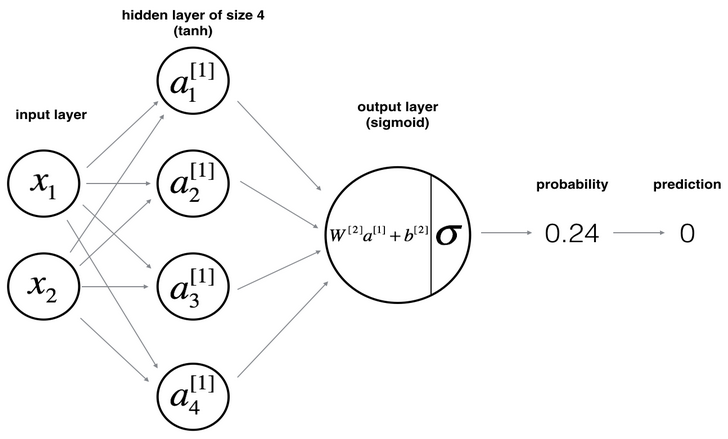

Secara matematis:

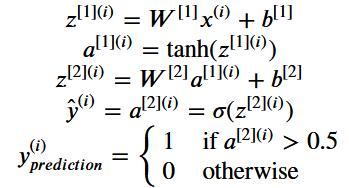

###Define fungsi-fungsi pemodelan

**Mendefine struktur neural network**

In [32]:
def ukuran_layer(X, Y):
  n_x = X.shape[0] # banyak input (2)
  n_h = 4 # banyak units (4)
  n_y = Y.shape[0] # banyak output (1)

  return (n_x, n_h, n_y)

**Inisialisasi parameter secara acak**

In [76]:
def initWb(n_x, n_h, n_y):
  W1 = np.random.randn(n_h, n_x) * 0.01 # shape(4,2)
  b1 = np.zeros((n_h, 1)) # shape(4,1)
  W2 = np.random.randn(n_y, n_h) * 0.01 # shape(1,4)
  b2 = np.zeros((n_y, 1)) # shape (1,1)
  # simpan parameter di dict params
  params = {"W1": W1,
            "b1": b1,
            "W2": W2,
            "b2": b2}

  return params

**Forward propagation**

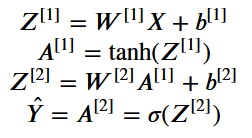

In [34]:
def forward(X, params):
  W1 = params['W1']
  b1 = params['b1']
  W2 = params['W2']
  b2 = params['b2']

  Z1 = np.dot(W1, X) + b1
  A1 = np.tanh(Z1) # output hidden layer 1
  Z2 = np.dot(W2, A1) + b2
  A2 = sigmoid(Z2) # output layer

  assert(A2.shape == (1, X.shape[1]))
  # simpan kalkulasi feed forward di dict cache
  cache = {"Z1": Z1,
           "A1": A1,
           "Z2": Z2,
           "A2": A2}
    
  return A2, cache

**Menghitung cost:** untuk menilai seberapa buruk model dalam memprediksi dengan parameters tertentu

Cost function:

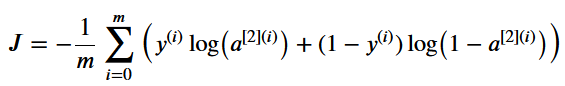

In [46]:
def hitung_cost(A2, Y): # hitung error output prediksi (A2) dan label asli (Y)
  m = Y.shape[1] # banyak data training
  loss = np.multiply(np.log(A2), Y) + np.multiply(np.log(1-A2), (1-Y))
  cost = - np.sum(loss)/m # mean loss
  cost = float(np.squeeze(cost)) # parse array jadi float
  
  return cost

**Backward Propagation**

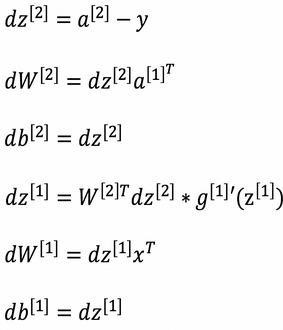

Dimana: 
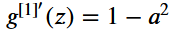

In [82]:
def backward(params, cache, X, Y):
  m = X.shape[1] # banyak data
  # weight
  W1 = params['W1']
  W2 = params['W2']

  # output aktivasi dari feed forward
  A1 = cache['A1']
  A2 = cache['A2']

  # gradien
  dZ2 = A2-Y
  dW2 = np.dot(dZ2, A1.T)/m
  db2 = np.sum(dZ2, axis=1, keepdims=True)/m
  dZ1 = np.multiply(np.dot(W2.T, dZ2), 1 - np.power(A1, 2))
  dW1 = np.dot(dZ1, X.T)/m
  db1 = np.sum(dZ1, axis=1, keepdims=True)/m

  grads = {"dW1": dW1,
            "db1": db1,
            "dW2": dW2,
            "db2": db2}
            
  return grads

**Optimizer**: Update parameter (weight dan bias) dengan gradient descent

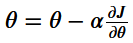

In [84]:
def optimize(params, grads, learning_rate = 1.2):
  W1 = params['W1']
  b1 = params['b1']
  W2 = params['W2']
  b2 = params['b2']

  dW1 = grads['dW1']
  db1 = grads['db1']
  dW2 = grads['dW2']
  db2 = grads['db2']

  # update weight dan bias
  # parameter baru = parameter saat ini - (penskala * turunan pertama dari parameter saat ini)
  W1 = W1 - learning_rate*dW1
  b1 = b1 - learning_rate*db1
  W2 = W2 - learning_rate*dW2
  b2 = b2 - learning_rate*db2

  # simpan kalkulasi
  params = {"W1": W1,
            "b1": b1,
            "W2": W2,
            "b2": b2}

  return params

###Pembuatan Model

In [93]:
def model(X, Y, n_h, iterasi = 10000, learning_rate=1.2, print_cost=False):
  np.random.seed(3)
  n_x = ukuran_layer(X, Y)[0]
  n_y = ukuran_layer(X, Y)[2]
  
  # inisialisasi weight dan bias
  params = initWb(n_x, n_h, n_y)
  
  # looping gradient descent
  for i in range(0, iterasi):
    # feed forward
    A2, cache = forward(X, params)
    # hitung cost
    cost = hitung_cost(A2, Y)
    # backprop
    grads = backward(params, cache, X, Y)
    # update weight dan bias
    params = optimize(params, grads, learning_rate)
    
    # rekam cost setiap 100 iterasi
    if print_cost and i % 1000 == 0:
        print ("Cost setelah iterasi %i: %f" %(i, cost))

  # output parameter hasil training
  return params

###Prediksi

In [86]:
def predict(params, X):
  # feed dengan parameter hasil training
  A2, cache = forward(X, params)
  predictions = (A2 > 0.5) # output dari sigmoid jika lebih dari 0.5 maka 1 else 0

  return predictions

### Train model

Cost setelah iterasi 0: 0.693162
Cost setelah iterasi 1000: 0.258625
Cost setelah iterasi 2000: 0.239334
Cost setelah iterasi 3000: 0.230802
Cost setelah iterasi 4000: 0.225528
Cost setelah iterasi 5000: 0.221845
Cost setelah iterasi 6000: 0.219094
Cost setelah iterasi 7000: 0.220651
Cost setelah iterasi 8000: 0.219406
Cost setelah iterasi 9000: 0.218484


Text(0.5, 1.0, 'Decision Boundary satu hidden layer dengan units 4')

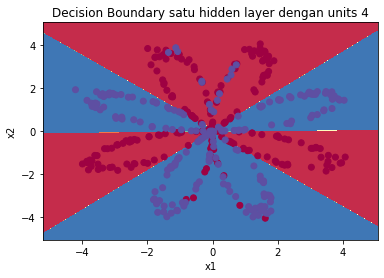

In [92]:
params = model(X, Y, n_h = 4, iterasi = 10000, learning_rate=1.2, print_cost=True)

plot_decision_boundary(lambda x: predict(params, x.T), X, Y)
plt.title("Decision Boundary satu hidden layer dengan units " + str(n_h))